In [138]:
!pip install rdkit py3Dmol
!pip install selfies
!pip install crem
!pip install rdkit

<a target="_blank" href="https://colab.research.google.com/drive/1D5NbTdCmuzG7DuFd5o3AVuLnSYXgugDt?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [139]:
# Import necessary libraries
import tqdm
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdDepictor
from rdkit.Chem import PandasTools, Descriptors
import py3Dmol

from IPython.display import display, HTML
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

import selfies as sf
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib
import matplotlib.pyplot as plt

from crem.crem import mutate_mol, grow_mol, link_mols
import matplotlib.pyplot as plt
import seaborn as sns

# Mutations of molecules #


Mutations in SMILES strings are a fundamental technique in computational chemistry and drug discovery for exploring the vast chemical space in search of novel molecules with desirable properties. <br>
By introducing random or targeted changes to the SMILES representation of molecules, researchers can generate new molecular structures that may exhibit improved biological activity, selectivity, or pharmacokinetic properties. This process, inspired by the principles of natural evolution and genetic variation, enables the iterative refinement of molecular candidates through cycles of mutation, evaluation, and selection. It's a powerful approach for optimizing existing drugs, discovering new therapeutic candidates, and understanding the relationship between molecular structure and biological function, ultimately accelerating the pace of pharmaceutical development and the discovery of novel materials. <br>

In this example, we’re not only converting the SMILES string `CCO` into a molecule object but also ensuring its validity through sanitization. If we set `sanitize=False` in `Chem.MolFromSmiles`, then we don’t need to to explicitly call Chem.SanitizeMo.


In [140]:
from rdkit import Chem

# Replace 'YOUR_SMILES_STRING' with an actual SMILES string
smile = 'CCO'

# Convert SMILES to molecule object with sanitize=False
molecule = Chem.MolFromSmiles(smile, sanitize=False)

# Check if the conversion was successful
if molecule is not None:
    print("Molecule object created successfully!")

    # Sanitize the molecule for validation
    Chem.SanitizeMol(molecule)

    # Check if sanitization was successful
    if Chem.SanitizeMol(molecule) == 0:
        print("Molecule sanitized successfully!")
    else:
        print("invalid chemistry")
else:
    print("invalid SMILES")



Molecule object created successfully!
Molecule sanitized successfully!


The following code demonstrates how to replace a dummy atom in a molecule with a real atom using RDKit. This example assumes you have a molecule with at least one dummy atom (denoted as * in SMILES) that you want to replace with another atom or group:

In [141]:
def replace_ghost_atom(smiles, replacement_smiles, atom_idx=None):
    """
    Replaces a dummy atom in a molecule with a specified atom or group.

    :param smiles: SMILES string of the original molecule containing a dummy atom.
    :param replacement_smiles: SMILES string of the atom or group to replace the dummy atom.
    :param atom_idx: Index of the dummy atom to replace. If None, replaces the first dummy atom found.
    :return: SMILES string of the modified molecule, or None if the operation fails.
    """
    mol = Chem.MolFromSmiles(smiles)
    replacement_mol = Chem.MolFromSmiles(replacement_smiles)

    if not mol or not replacement_mol:
        return None

    # Find the dummy atoms
    dummy_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == '*']
    if not dummy_atoms:
        return None

    # Select the dummy atom to replace
    if atom_idx is not None and atom_idx in dummy_atoms:
        dummy_atom_idx = atom_idx
    else:
        dummy_atom_idx = dummy_atoms[0]  # Default to the first dummy atom

    # Replace the dummy atom
    editable_mol = Chem.EditableMol(mol)
    editable_mol.ReplaceAtom(dummy_atom_idx, replacement_mol.GetAtomWithIdx(0))
    modified_mol = editable_mol.GetMol()

    # Sanitize the molecule (optional but recommended)
    Chem.SanitizeMol(modified_mol)

    return Chem.MolToSmiles(modified_mol)

# Example usage
original_smiles = "C1=CC=CC=C1*"  # Benzene with a dummy atom
# replacement_smiles = "O"  # Replace dummy atom with oxygen
possible_characters = ['c','C', 'O', 'N', '=', '#', '(', ')','=O','#N','=N']
good_molecules = [original_smiles]
for ci in possible_characters:
  modified_smiles = replace_ghost_atom(original_smiles, ci)
  print(f"Original SMILES: {original_smiles}",f"Modified SMILES: {modified_smiles}")
  if modified_smiles is not None:
    good_molecules.append(modified_smiles)


Original SMILES: C1=CC=CC=C1* Modified SMILES: None
Original SMILES: C1=CC=CC=C1* Modified SMILES: Cc1ccccc1
Original SMILES: C1=CC=CC=C1* Modified SMILES: Oc1ccccc1
Original SMILES: C1=CC=CC=C1* Modified SMILES: Nc1ccccc1
Original SMILES: C1=CC=CC=C1* Modified SMILES: None
Original SMILES: C1=CC=CC=C1* Modified SMILES: None
Original SMILES: C1=CC=CC=C1* Modified SMILES: None
Original SMILES: C1=CC=CC=C1* Modified SMILES: None
Original SMILES: C1=CC=CC=C1* Modified SMILES: None
Original SMILES: C1=CC=CC=C1* Modified SMILES: None
Original SMILES: C1=CC=CC=C1* Modified SMILES: None


[19:06:42] non-ring atom 0 marked aromatic
[19:06:42] SMILES Parse Error: syntax error while parsing: =
[19:06:42] SMILES Parse Error: Failed parsing SMILES '=' for input: '='
[19:06:42] SMILES Parse Error: syntax error while parsing: #
[19:06:42] SMILES Parse Error: Failed parsing SMILES '#' for input: '#'
[19:06:42] SMILES Parse Error: syntax error while parsing: (
[19:06:42] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[19:06:42] SMILES Parse Error: syntax error while parsing: )
[19:06:42] SMILES Parse Error: Failed parsing SMILES ')' for input: ')'
[19:06:42] SMILES Parse Error: syntax error while parsing: =O
[19:06:42] SMILES Parse Error: Failed parsing SMILES '=O' for input: '=O'
[19:06:42] SMILES Parse Error: syntax error while parsing: #N
[19:06:42] SMILES Parse Error: Failed parsing SMILES '#N' for input: '#N'
[19:06:42] SMILES Parse Error: syntax error while parsing: =N
[19:06:42] SMILES Parse Error: Failed parsing SMILES '=N' for input: '=N'


['C1=CC=CC=C1*', 'Cc1ccccc1', 'Oc1ccccc1', 'Nc1ccccc1']


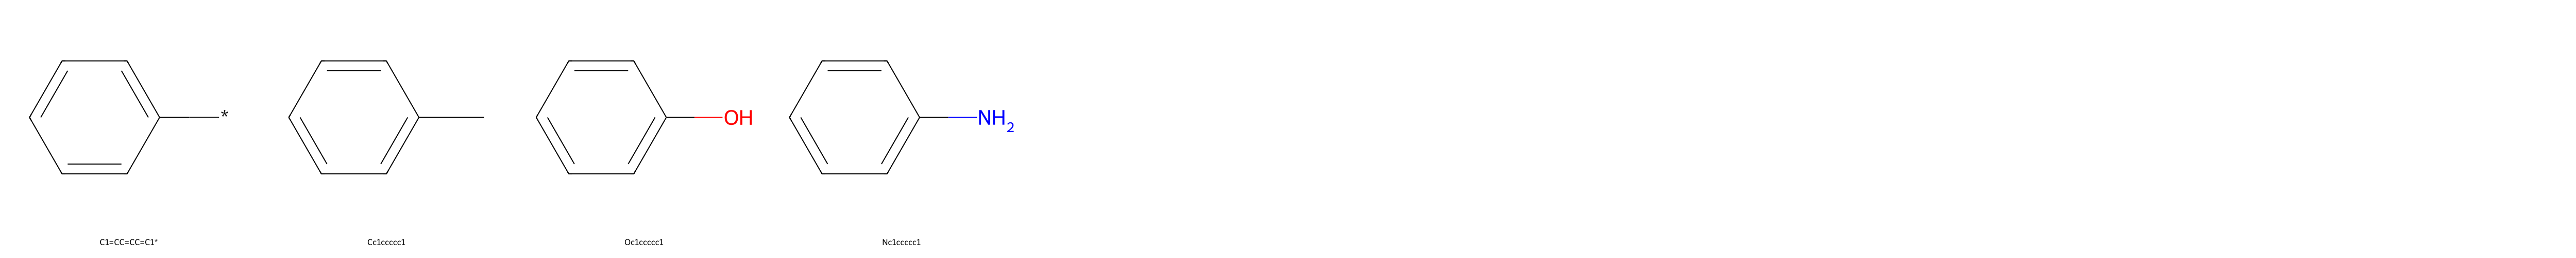

In [142]:
print(good_molecules)
mol_good_molecules = [Chem.MolFromSmiles(si, sanitize=False) for si in good_molecules]

img = Draw.MolsToGridImage(mol_good_molecules, molsPerRow=10, subImgSize=(500, 500), legends=good_molecules)
img


# SELFIES #
# **Introduction to SELFIES**

Chemistry and computational analysis often grapple with the complexity of molecular representation. SELFIES (Self-Referencing Embedded Strings) is a robust molecular string representation system designed for unambiguous molecular encoding. Its key advantage lies in facilitating direct input into machine learning models, such as generative models, and ensuring the validity of the outputs.

## **Key Points of SELFIES**

- Robustness: Each SELFIES string is a valid molecular structure, overcoming the validity issues of other formats.
- Generative Model Compatibility: SELFIES offers a diverse array of valid molecules, enhancing generative model outcomes.
- Adjustable Constraints: The framework can impose both meaningful and arbitrary rule sets, showcasing its adaptability.
- Syntax and Grammar: SELFIES uses a context-free grammar with specific symbols for atoms, rings, branches, and more.

<br>

<!DOCTYPE html>
<html>
<head>
    <style>
        .centered-image {
            display: block;
            margin-left: auto;
            margin-right: auto;
            width: 50%;
        }
    </style>
</head>
<body>

<a href="https://aspuru.substack.com/p/molecular-graph-representations-and" target="_blank">
    <img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F6e37c68a-a71c-4ffa-ba5c-ffe1e237a5c3_1600x859.png"
         alt="SMILES and SELFIES compared."
         class="centered-image">
</a>

<br>
<figcaption align = "center"><b>Figure 1 - SMILES and SELFIES compared. Figure from
Alan Aspuru-Guzik.</b></figcaption>


## **Pros and Cons of SELFIES:**

### **Pros of SELFIES:**
- **Consistency**: SELFIES ensures that each molecule is represented by a unique string, which aids in maintaining database integrity and simplifying molecule comparisons.
- **Generative Model Synergy**: Training with SELFIES results in a higher diversity of valid, novel molecules compared to SMILES, benefiting the exploration of chemical space.

### **Cons of SELFIES:**
- **Complexity**: The SELFIES syntax is more complex and less human-readable than SMILES, which can be a barrier for manual handling and interpretation.
- **Adoption**: While gaining popularity, SELFIES is newer and less widespread than SMILES, potentially leading to compatibility issues with existing systems.



## **Rules:**
1. The main string is derived using a rule set such that the number of valence bonds per atom does not exceed physical limits.
2. The symbol after a `Branch` is interpreted as the number of
SELFIES symbols derived inside the branch.
3. The symbol after `Ring` interpreted as a number too, indicating that the current atom is connected to the `(N + 1)`st previous atom.
Thereby every information in the string (except the ring
closure) is local and allows for efficient derivation rules.


## **SELFIES vs. SMILES Representation**

In chemical informatics, SELFIES and SMILES are two methods used for representing molecules as strings. While SMILES is the more traditional format, SELFIES is a newer format designed to overcome some of the limitations of SMILES.


## **Symbol Indexing in SELFIES**

The SELFIES format uses indexed symbols, such as `[Branch1]` or `[Ring1]`, which refer to specific structural elements. All other symbols are assigned index 0 by default. For example:
- `[Branch1][size=1]` indicates a branch of size index+1
- `[Ring2]` denotes a ring closure







## **Using SELFIES:**
SELFIES excel in generating random molecules and one-hot encoding for machine learning using valid SELFIE alphabets and external information such as ring structures.

> The following code has been adopted and added from [Akshat Nigam &
Aspuru-Guzik group's GitHub](https://github.com/aspuru-guzik-group/selfies_tutorial/tree/master)

In [143]:
# import selfies as sf

# List of molecules with their common names and SMILES representation
molecules = [
    ("Benzene", "c1ccccc1"),
    ("Caffeine", "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"),
    ("Aspirin", "CC(=O)OC1=CC=CC=C1C(=O)O"),
    ("Methane", "C"),
    ("Ethanol", "CCO"),
    ("Glucose", "C(C1C(C(C(C(O1)O)O)O)O)O"),
    ("Acetic Acid", "CC(=O)O"),
    ("Penicillin", "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C"),
    ("Naproxen", "CC(C1=CC=CC=C1)C(C2=CC=C(C=C2)C(=O)O)C(=O)O")
]

# Prepare lists to store data for DataFrame
common_names, smiles_list, encoded_selfies_list, decoded_smiles_list = [], [], [], []

# Process each molecule
for common_name, smiles in molecules:
    common_names.append(common_name)
    smiles_list.append(smiles)

    # SMILES --> SELFIES translation
    encoded_selfies = sf.encoder(smiles)
    encoded_selfies_list.append(encoded_selfies)

    # SELFIES --> SMILES translation
    decoded_smiles = sf.decoder(encoded_selfies)
    decoded_smiles_list.append(decoded_smiles)

# Create DataFrame
df = pd.DataFrame({
    "Common Name": common_names,
    "SMILES": smiles_list,
    "Encoded SELFIES": encoded_selfies_list,
    "Decoded SMILES": decoded_smiles_list
})

pd.set_option('display.max_colwidth', None)


df.head(9)


,Common Name,SMILES,Encoded SELFIES,Decoded SMILES
0,Benzene,c1ccccc1,[C][=C][C][=C][C][=C][Ring1][=Branch1],C1=CC=CC=C1
1,Caffeine,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,[C][N][C][=N][C][=C][Ring1][Branch1][C][=Branch1][C][=O][N][Branch1][=Branch2][C][=Branch1][C][=O][N][Ring1][Branch2][C][C],CN1C=NC2=C1C(=O)N(C(=O)N2C)C
2,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,[C][C][=Branch1][C][=O][O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=Branch1][C][=O][O],CC(=O)OC1=CC=CC=C1C(=O)O
3,Methane,C,[C],C
4,Ethanol,CCO,[C][C][O],CCO
5,Glucose,C(C1C(C(C(C(O1)O)O)O)O)O,[C][Branch2][Ring1][Branch1][C][C][Branch1][S][C][Branch1][N][C][Branch1][Branch2][C][Branch1][Ring2][O][Ring1][=Branch1][O][O][O][O][O],C(C1C(C(C(C(O1)O)O)O)O)O
6,Acetic Acid,CC(=O)O,[C][C][=Branch1][C][=O][O],CC(=O)O
7,Penicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,[C][C][Branch2][Ring2][=Branch1][C][Branch2][Ring1][=N][N][C][Branch1][Ring2][S][Ring1][Branch1][C][Branch1][Branch1][C][Ring1][Branch1][=O][N][C][=Branch1][C][=O][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=Branch1][C][=O][O][C],CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C
8,Naproxen,CC(C1=CC=CC=C1)C(C2=CC=C(C=C2)C(=O)O)C(=O)O,[C][C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][S][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][C][=Branch1][C][=O][O][C][=Branch1][C][=O][O],CC(C1=CC=CC=C1)C(C2=CC=C(C=C2)C(=O)O)C(=O)O


In [144]:
# Retrieve the list of robust alphabets from SELFIES
robust_alphabets = list(sf.get_semantic_robust_alphabet())

# Creating a DataFrame for the robust alphabets
df = pd.DataFrame(robust_alphabets, columns=['Robust Alphabets'])

# Print the number of characters and the DataFrame
print(f"Number of Characters in Robust Alphabets: {len(robust_alphabets)}")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 70)

df

Number of Characters in Robust Alphabets: 69


,Robust Alphabets
0,[Cl]
1,[O+1]
2,[=C]
3,[O-1]
4,[N-1]
5,[C]
6,[I]
7,[#C+1]
8,[#S-1]
9,[=N+1]


In [145]:
# A subset of SELFIE alphabets
alphabet_random = ['[=O]', '[O]', '[Ring2]', '[#Branch2]', '[#Branch3]'
            '[N]', '[=Ring3]', '[#B]', '[H]',
            '[#P]', '[Cl]', '[F]', '[Ring1]', '[P]', '[=Branch2]',
            '[Br]', '[=S]', '[=N]', '[#N]', '[S]',
            '[C]', '[I]', '[Ring3]', '[=C]', '[#C]'] + ['[C][=C][C][=C][C][=C][Ring1][=Branch1]'] * 10


def get_random_molecule_using_selfies(num_random, robust_alphabets):
    max_smi_len = 25
    min_smi_len = 5
    collect_random = []

    for _ in range(num_random):
        random_len = random.randint(min_smi_len, max_smi_len+1)
        random_alphabets = list(np.random.choice(alphabet_random, random_len))
        random_selfies = ''.join(x for x in random_alphabets)

        collect_random.append(sf.decoder(random_selfies))

    return [x for x in collect_random if x != '']

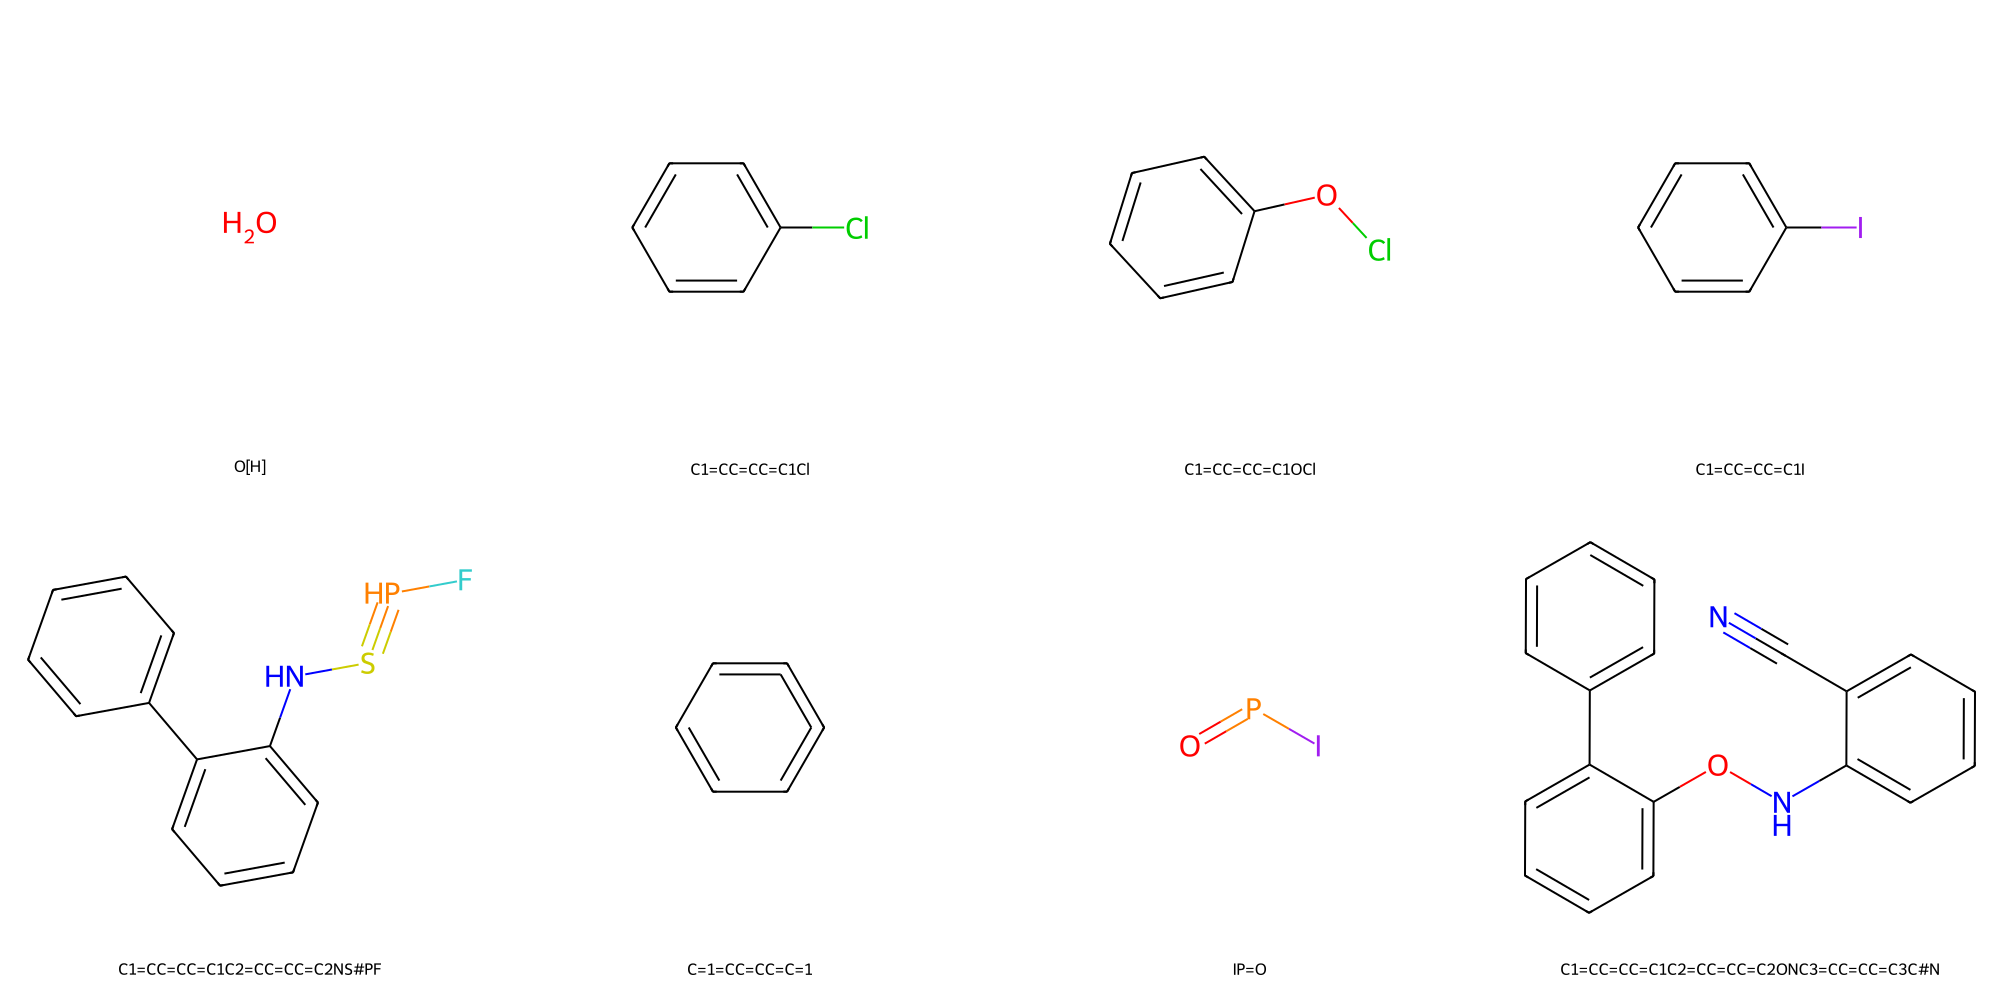

In [146]:
random_smiles = get_random_molecule_using_selfies(8, alphabet_random)

mols = [Chem.MolFromSmiles(smi) for smi in random_smiles]
img = Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(500, 500), legends=random_smiles)
img

> While some of these molecules may contain unresonable connections between functional groups, they are all **valid** molecules.

### **Using SELFIES to explore analogous of Acetaminophen**
By using a variation of the  ``` def get_random_molecule_using_selfies  ``` function, let's explore variations of Acetaminophen.

```
def get_random_molecule_using_selfies(num_random, robust_alphabets):
    max_smi_len = 25
    min_smi_len = 2
    collect_random = []
    
    for _ in range(num_random):
        random_len = random.randint(min_smi_len, max_smi_len+1)
        random_alphabets = list(np.random.choice(alphabet, random_len))
        random_selfies = ''.join(x for x in random_alphabets)
        
        collect_random.append(sf.decoder(random_selfies))
    
    return [x for x in collect_random if x != '']
```




In [147]:
acetaminophen_alphabet = ['[=O]', '[O]', '[Ring2]', '[#Branch2]', '[#Branch3]',
                          '[N]', '[=Ring3]', '[Ring1]', '[P]', '[H]', '[#Branch1]'
                          '[Br]', '[=S]', '[=N]', '[#N]', '[S]', '[=Ring2]', '[=Branch1]',
                          '[C]', '[Ring3]', '[=C]', '[#C]' , '[#C+1]' , '[=N+1]']

acetaminophen_smiles = 'CC(=O)Nc1ccc(cc1)O'

def get_random_acetaminophen(num_random):
    max_extra_len = 25
    min_extra_len = 3
    collect_random = []

    for _ in range(num_random):
        random_len = random.randint(min_extra_len, max_extra_len)
        random_alphabets = list(np.random.choice(acetaminophen_alphabet, random_len))
        random_selfies = ''.join(random_alphabets)

        # Encoding acetaminophen_smiles and appending random_selfies
        encoded_smiles = sf.encoder(acetaminophen_smiles) + random_selfies
        decoded_smiles = sf.decoder(encoded_smiles)
        if decoded_smiles is not None or decoded_smiles:
            collect_random.append(decoded_smiles)

    return collect_random

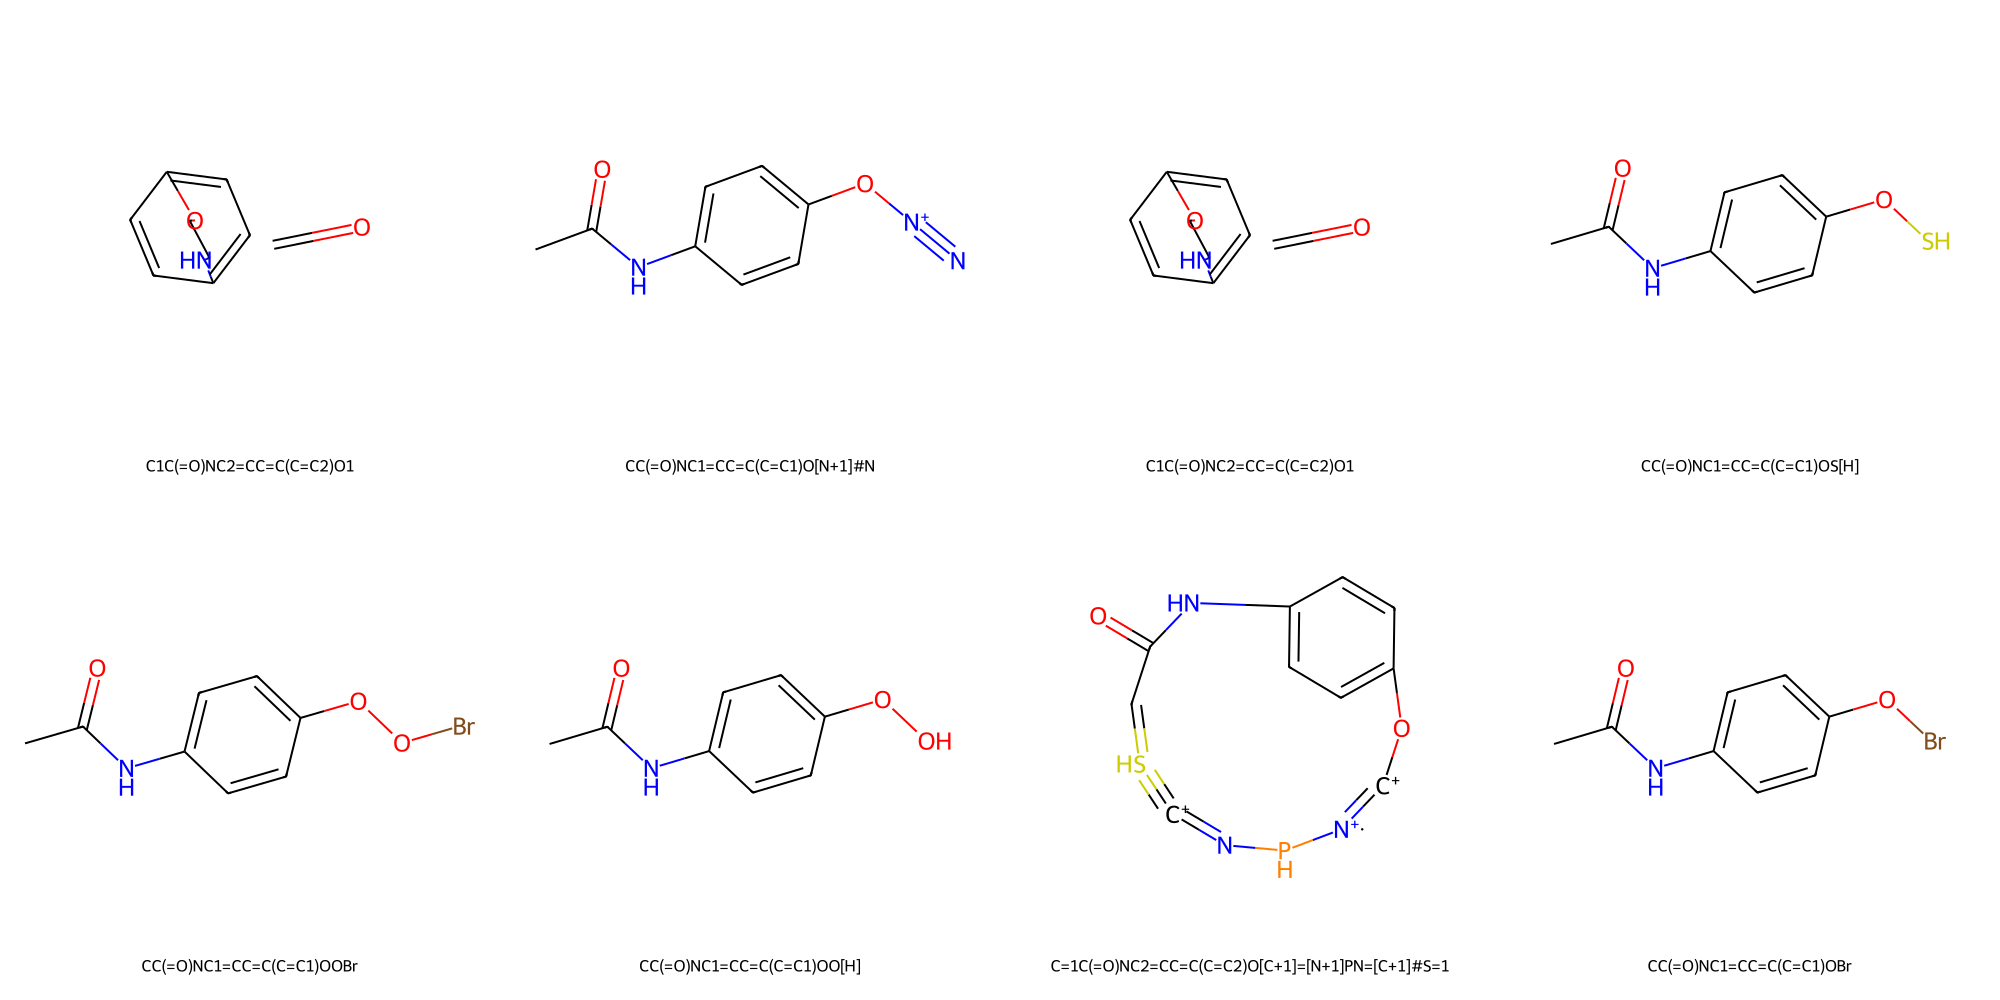

In [148]:
random_acetaminophen = get_random_acetaminophen(8)

ace_mols = [Chem.MolFromSmiles(ace_smi) for ace_smi in random_acetaminophen]
img = Draw.MolsToGridImage(ace_mols[:8], molsPerRow=4, subImgSize=(500, 500), legends=random_acetaminophen)
img

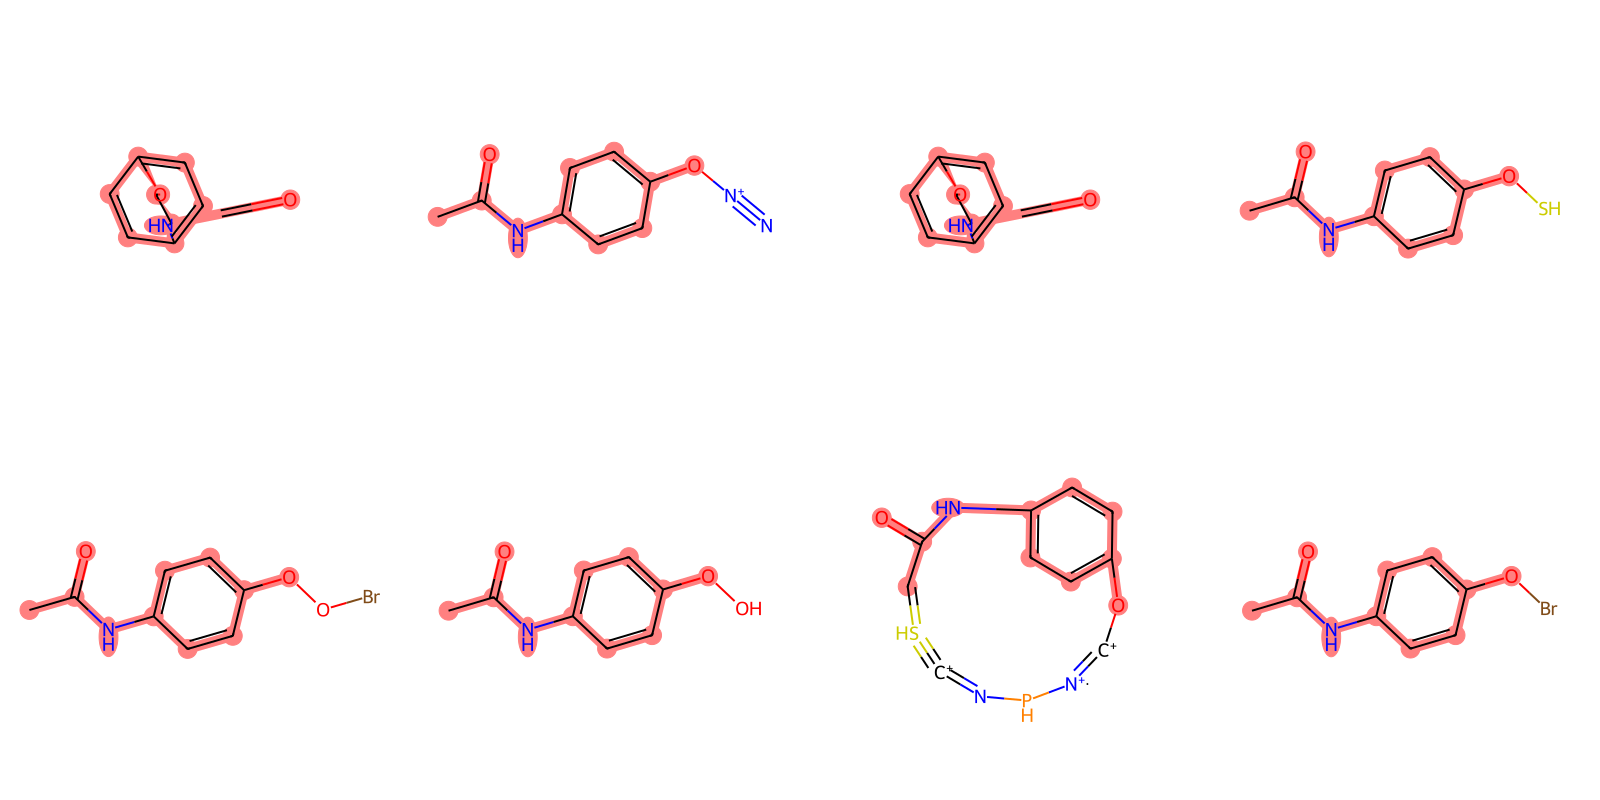

In [149]:
mols = []
highlights = []
acetaminophen_mol = Chem.MolFromSmiles(acetaminophen_smiles)

for ace_smi in random_acetaminophen:
    mol = Chem.MolFromSmiles(ace_smi)
    mols.append(mol)
    # Find the substructure
    if mol.HasSubstructMatch(acetaminophen_mol):
        substruct = mol.GetSubstructMatch(acetaminophen_mol)
        highlights.append(substruct)
    else:
        highlights.append([])

# Draw the molecules with highlighted substructure
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(400, 400), highlightAtomLists=highlights)
img

### **One-Hot Encoding**

In [150]:
# Encode molecules to SELFIES
encoded_one_hot_random = [sf.encoder(molecule) for molecule in random_acetaminophen]

# Determine the alphabet from the encoded molecules, include padding symbol
molecule_alphabet_random = sf.get_alphabet_from_selfies(encoded_one_hot_random)
molecule_alphabet_random.add('[nop]')
molecule_alphabet_random = list(sorted(molecule_alphabet_random))

# Calculate maximum length for padding
max_length = max(sf.len_selfies(s) for s in encoded_one_hot_random)

# Mapping from symbols to indices
symbol_to_index_random = {s: i for i, s in enumerate(molecule_alphabet_random)}

# Mapping from indices to symbols (reverse of symbol_to_index)
vocab_itos_random = {i: s for s, i in symbol_to_index_random.items()}

# Convert molecules to label-encoded and one-hot encoded formats
encoded_data = []
for molecule in encoded_one_hot_random:
    label_encoded = sf.selfies_to_encoding(molecule,
                                           vocab_stoi=symbol_to_index_random,
                                           pad_to_len=max_length,
                                           enc_type='label')
    one_hot_encoded = sf.selfies_to_encoding(molecule,
                                             vocab_stoi=symbol_to_index_random,
                                             pad_to_len=max_length,
                                             enc_type='one_hot')
    encoded_data.append((molecule, label_encoded, one_hot_encoded))

# Create DataFrame
df_encoded_one_hot_random = pd.DataFrame(encoded_data, columns=['Molecule SELFIES', 'Label Encoded', 'One-Hot Encoded'])

df_encoded_one_hot_random.head(8)

,Molecule SELFIES,Label Encoded,One-Hot Encoded
0,[C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][O][Ring1][O],"[11, 11, 2, 11, 6, 14, 11, 4, 11, 4, 9, 9, 11, 4, 17, 2, 15, 17, 15, 19, 19, 19, 19, 19, 19]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]"
1,[C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][O][N+1][#N],"[11, 11, 2, 11, 6, 14, 11, 4, 11, 4, 9, 9, 11, 4, 17, 2, 15, 13, 0, 19, 19, 19, 19, 19, 19]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]"
2,[C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][O][Ring1][O],"[11, 11, 2, 11, 6, 14, 11, 4, 11, 4, 9, 9, 11, 4, 17, 2, 15, 17, 15, 19, 19, 19, 19, 19, 19]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 

In [151]:
print(vocab_itos_random)

{0: '[#N]', 1: '[#S]', 2: '[=Branch1]', 3: '[=C+1]', 4: '[=C]', 5: '[=N+1]', 6: '[=O]', 7: '[=Ring1]', 8: '[Br]', 9: '[Branch1]', 10: '[C+1]', 11: '[C]', 12: '[H]', 13: '[N+1]', 14: '[N]', 15: '[O]', 16: '[P]', 17: '[Ring1]', 18: '[S]', 19: '[nop]'}


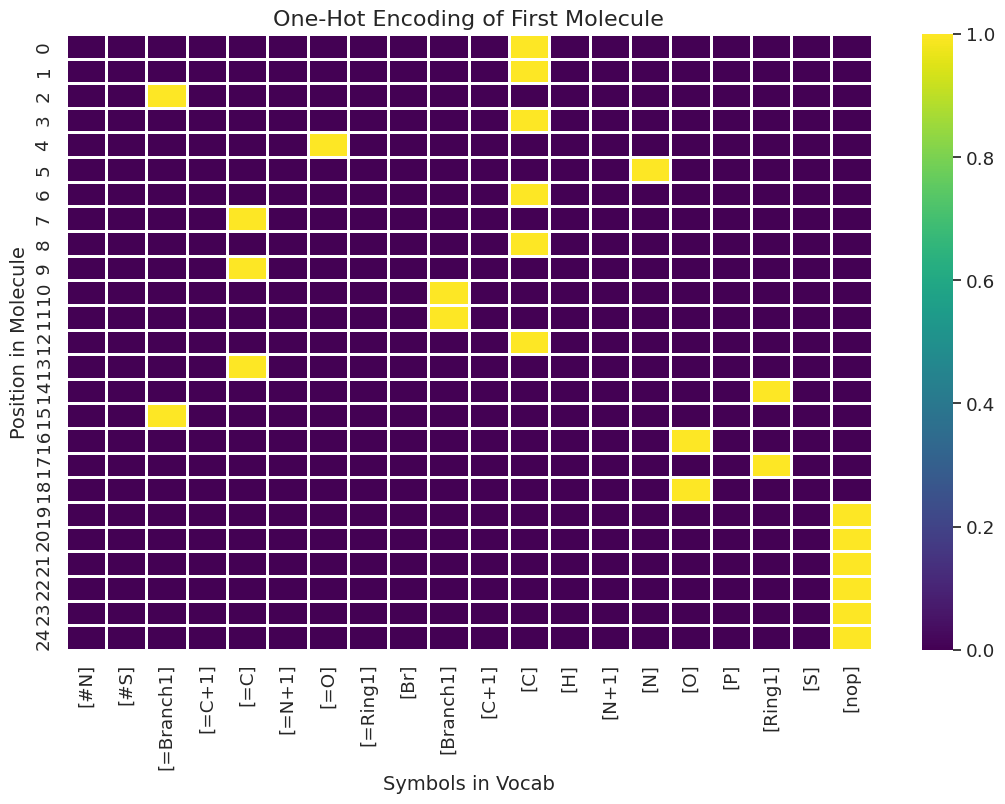

In [152]:
# Choose the first one-hot encoded molecule for visualization
one_hot_encoded_data = [data[2] for data in encoded_data]  # Replace '2' with the correct index for one-hot encoded data
first_molecule_one_hot = one_hot_encoded_data[0]  # Select the first molecule

# Create a list of symbols ordered by the index
ordered_symbols = [vocab_itos_random[i] for i in range(len(vocab_itos_random))]


# Enhanced plotting
plt.figure(figsize=(13, 8))
sns.set(font_scale=1.2)  # Increase font scale
heatmap = sns.heatmap(first_molecule_one_hot, cmap="viridis", cbar=True, linewidths= 1)
heatmap.set_xticks(np.arange(len(ordered_symbols)) + 0.5)
heatmap.set_xticklabels(ordered_symbols, rotation=90)
heatmap.set_xlabel("Symbols in Vocab", fontsize=14)
heatmap.set_ylabel("Position in Molecule", fontsize=14)
heatmap.set_title("One-Hot Encoding of First Molecule", fontsize=16)
plt.show()

In [153]:
# Select two random one-hot encoded molecules
selected_indices = random.sample(range(len(encoded_data)), 2)
selected_molecules = [encoded_data[i][2] for i in selected_indices]  # One-hot encoded

# Decode and filter '[nop]'
decoded_selfies = []
for one_hot in selected_molecules:
    decoded = sf.encoding_to_selfies(one_hot, vocab_itos_random, enc_type="one_hot")
    filtered_selfies = decoded.replace('[nop]', '')  # Remove '[nop]'
    decoded_selfies.append(filtered_selfies)

# Optionally convert to SMILES
decoded_smiles = [sf.decoder(s) for s in decoded_selfies]

# Displaying the decoded and filtered molecules
for idx, (selfies, smiles) in enumerate(zip(decoded_selfies, decoded_smiles)):
    print(f"Molecule {idx + 1}:")
    print("SELFIES:", selfies)
    print("SMILES:", smiles)

Molecule 1:
SELFIES: [C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][O][Ring1][O]
SMILES: C1C(=O)NC2=CC=C(C=C2)O1
Molecule 2:
SELFIES: [C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][O][N+1][#N]
SMILES: CC(=O)NC1=CC=C(C=C1)O[N+1]#N


# **Classification of molecules using CNN**

**Goals**
1. Introduction to SMILES as molecular representation for ML models.
2. Use ML models, more specifically **Convolutional NeuralNetworks** to classify molecules.



## **Data loading and analysis**

The Tox21 dataset from MoleculeNet is another baseline to test our model [37]. It contains the activities of 7,831 compounds against 12 biological targets or pathways, which are nuclear receptor(NR)-androgen receptor (AR)-ligand-binding domain (LBD), NR-AR, NR-aryl hydrocarbon receptor (AhR), NR-Aromatase, NR-estrogen receptor (ER)-LBD, NR-peroxisome proliferator-activated receptor (PPAR)-gamma, SR-antioxidant response element (ARE), stress response (SR)-ATPase Family AAA Domain Containing 5 (ATAD5), SR-heat shock factor response element (HSE), SR-mitochondrial membrane potential (MMP), and SR-p53 [38]. Similar to the CYP450 dataset, Tox21 includes many missing labels. We formulate the chemical toxicity prediction using the Tox21 dataset as a multi-label classification problem. The label for the target is positive if the chemical compound has toxicity by interacting with the target. The multi-label means one chemical compound can have more than one targets.

Text from the [link](https://bio-protocol.org/exchange/minidetail?type=30&id=12688188)

Total data: NR-AR            7439
NR-AR-LBD        6902
NR-AhR           6691
NR-Aromatase     5940
NR-ER            6316
NR-ER-LBD        7112
NR-PPAR-gamma    6583
SR-ARE           5935
SR-ATAD5         7232
SR-HSE           6594
SR-MMP           5920
SR-p53           6909
mol_id           8014
smiles           8014
dtype: int64
Possible values of NR-AR: [ 0. nan  1.]
Possible values of NR-AR: [0 1]
                                 smiles  NR-AR
0          CCOc1ccc2nc(S(N)(=O)=O)sc2c1      0
1             CCN1C(=O)NC(c2ccccc2)C1=O      0
3       CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C      0
4             CC(O)(P(=O)(O)O)P(=O)(O)O      0
5  CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C      0


<ipython-input-154-664f67522b7f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NR-AR'] = data['NR-AR'].astype(int)


array([[<Axes: title={'center': 'NR-AR'}>]], dtype=object)

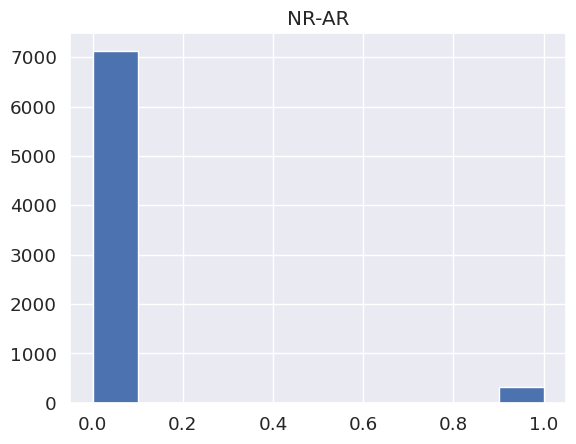

In [154]:
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/w2024/Course_Notes/data/tox21.csv"
data_full = pd.read_csv(data_url)
print('Total data:', data_full.count())
data_full.head()
data_full = data_full[['smiles','NR-AR']]

print('Possible values of NR-AR:', data_full['NR-AR'].unique())

data = data_full.dropna()
data['NR-AR'] = data['NR-AR'].astype(int)

print('Possible values of NR-AR:', data['NR-AR'].unique())
print(data.head())
data.hist(column='NR-AR')

> Plot some molecules that are not **HIV active**

[19:06:45] WARNING: not removing hydrogen atom without neighbors
/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


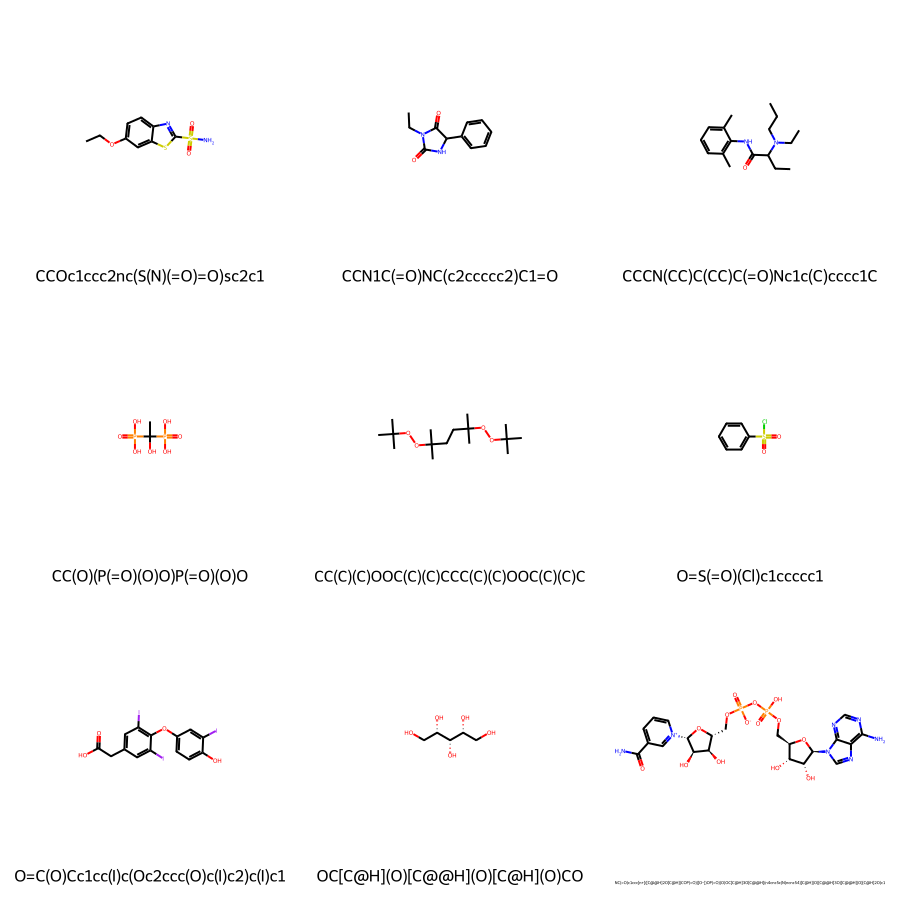

In [155]:
PandasTools.AddMoleculeColumnToFrame(data, 'smiles')
HIV_active_0 = data[data['NR-AR'] == 0]
HIV_active_0_16 = PandasTools.FrameToGridImage(HIV_active_0[:9], column='ROMol', legendsCol='smiles',
                                               molsPerRow=3, subImgSize=(300, 300))
HIV_active_0_16

[19:06:46] WARNING: not removing hydrogen atom without neighbors


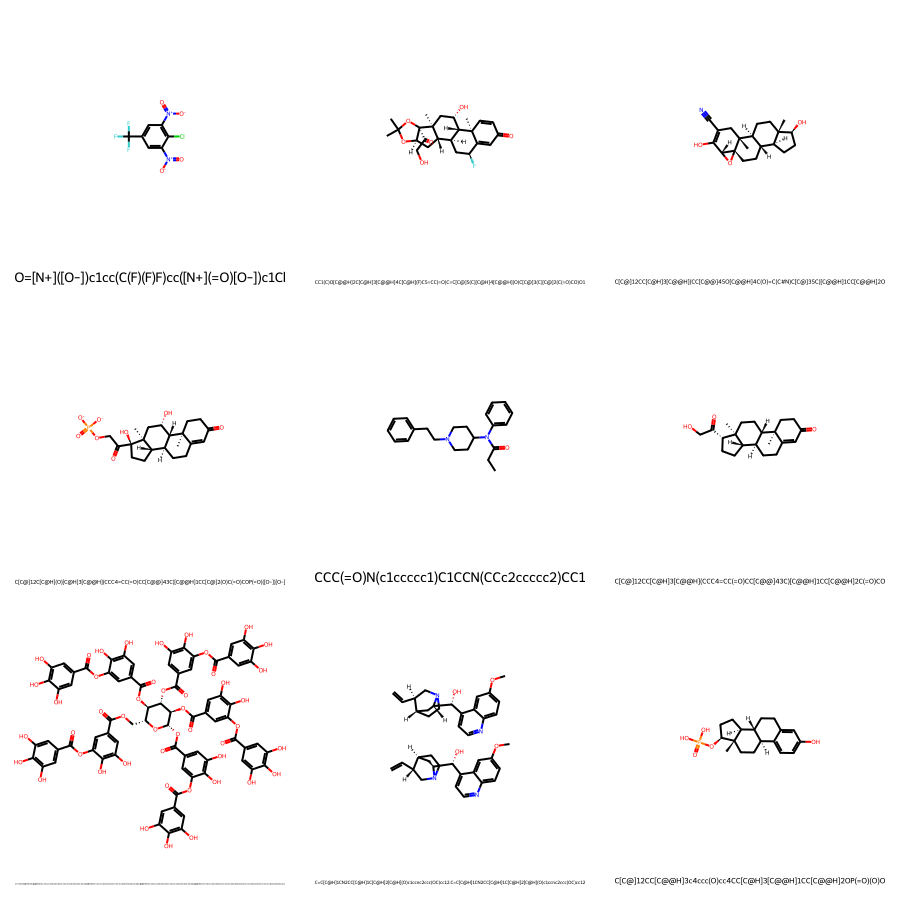

In [156]:
PandasTools.AddMoleculeColumnToFrame(data, 'smiles')
HIV_active_0 = data[data['NR-AR'] == 1]
HIV_active_0_16 = PandasTools.FrameToGridImage(HIV_active_0[:9], column='ROMol', legendsCol='smiles',
                                               molsPerRow=3, subImgSize=(300, 300))
HIV_active_0_16

From the previous class, we saw that a molecule written in the SMILES notation can be transformed into a *"figure"* using a dictionary of characters and the one-hot encoding transformation. <br>

To create this dictionary, we first need to defined the maximum number of characters in a SMILE, meaning the length of the text.

In [175]:
data_negative = data[data['NR-AR'] == 0]
data_positive = data[data['NR-AR'] == 1]

# balanced dataset
data_positive_d = pd.concat([data_positive, data_positive], axis=0)
n_positive = len(data_positive_d)
data_negative_red = data_negative.sample(n_positive)

balanced_data = pd.concat([data_negative_red, data_positive_d], axis=0)
balanced_data.head()
print(balanced_data.count())

smiles    1240
NR-AR     1240
ROMol     1240
dtype: int64


In [176]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


In [219]:
global_alphabet = ['[=O]', '[O]', '[Ring2]', '[#Branch2]', '[#Branch3]', '[=Ring1]', '[=Ring2]',
                     '[N]', '[=Ring3]', '[#B]', '[H]', '[#P]', '[Cl]', '[#Branch1]', '[As]',
                     '[F]', '[Ring1]', '[P]', '[=Branch2]', '[Br]', '[NH1]', '[=N-1]', '[NaH1]',
                     '[=S]', '[=N]', '[#N]', '[S]', '[C]', '[I]', '[=N+1]', '[Mn+1]', '[Cl-1]',
                     '[Ring3]', '[=C]', '[#C]', '[Ag]', '[Pt]', '[K]', '[PH1]', '[N+1]',
                     '[Rh]', '[Zn]', '[Hg]', '[Fe]', '[Te]', '[Ca]', '[Se]', '.', '[=P]',
                     '[Li]', '[Mg]', '[Ge]', '[Cu]', '[Mo]', '[Mn]', '[Si]', '[O-1]',
                     '[Ni]', '[W]', '[U]', '[Branch1]', '[Branch2]', '[=Branch1]','[C@]',
                   '[C@H1]','[C@@H1]','[C@@]', '[N-1]','[/C]','[\\C]','[NH1+1]', '[/N]',
                   '[/O]','[Sb]','[\\C@H1]','[\\N+1]','[Mn+2]','[AlH3]','[=Mo]','[/C@@H1]',
                   '[Sn]','[Ba+2]','[=S+1]','[Cu+2]','[Na]','[=Bi]','[Fe+2]','[B-1]','[B]',
                   '[Pd]','[Au-1]','[S-1]','[\\Cl]','[Zn+2]','[\\O]','[K+1]','[Br-1]','[In]',
                   '[\\S]','[Na+1]','[SbH6+3]', '[SiH1]', '[\\N]',  '[N@@+1]', '[I-1]', '[Hg+2]',
                   '[PbH2+2]','[Fe+3]','[Fe-1]','[NH3+1]','[Bi]','[=Se]','[NH4+1]','[Co+2]',
                   '[/C@H1]','[P+1]','[S+1]','[Cr+2]','[CH1-1]','[Dy]','[Ni+2]','[TlH2+1]',
                   '[nop]']



def smiles_to_one_hot_and_list(smile, max_length, alphabet=global_alphabet):
    """
    Converts a SMILES string to a one-hot encoded matrix and a list of SELFIES symbols.
    """
    selfies_str = sf.encoder(smile)

    molecule_alphabet = sorted(alphabet)

    symbol_to_index = {s: i for i, s in enumerate(molecule_alphabet)}
    vocab_itos = {i: s for s, i in symbol_to_index.items()}
    one_hot_encoded = sf.selfies_to_encoding(selfies_str,
                                             vocab_stoi=symbol_to_index,
                                             pad_to_len=max_length,
                                             enc_type='one_hot')

    selfies_list = selfies_str.split('][')
    selfies_list[0] = selfies_list[0][1:]
    selfies_list[-1] = selfies_list[-1][:-1]
    selfies_output_list = ['[' + selfie + ']' for selfie in selfies_list]
    one_hot_encoded = np.array(one_hot_encoded).T
    # Padding
    if one_hot_encoded.shape[0] < max_length:
        padding = np.zeros((max_length - one_hot_encoded.shape[0], one_hot_encoded.shape[1]))
        one_hot_encoded = np.vstack((one_hot_encoded, padding))

    return one_hot_encoded, symbol_to_index, vocab_itos, selfies_output_list

smile = 'CC(C)C(C(=O)O)n1[se]c2ccccc2c1=O'
selfies_str = sf.encoder(smile)

max_l = sf.len_selfies(selfies_str) + 10

one_hot_encoded, symbol_to_index, vocab_itos, selfies_tokens = smiles_to_one_hot_and_list(smile, max_l)

print('SELFIES image:', one_hot_encoded.shape)

print(symbol_to_index)
print(vocab_itos)
print(selfies_tokens)


SELFIES image: (123, 37)
{'.': 0, '[#B]': 1, '[#Branch1]': 2, '[#Branch2]': 3, '[#Branch3]': 4, '[#C]': 5, '[#N]': 6, '[#P]': 7, '[/C@@H1]': 8, '[/C@H1]': 9, '[/C]': 10, '[/N]': 11, '[/O]': 12, '[=Bi]': 13, '[=Branch1]': 14, '[=Branch2]': 15, '[=C]': 16, '[=Mo]': 17, '[=N+1]': 18, '[=N-1]': 19, '[=N]': 20, '[=O]': 21, '[=P]': 22, '[=Ring1]': 23, '[=Ring2]': 24, '[=Ring3]': 25, '[=S+1]': 26, '[=S]': 27, '[=Se]': 28, '[Ag]': 29, '[AlH3]': 30, '[As]': 31, '[Au-1]': 32, '[B-1]': 33, '[B]': 34, '[Ba+2]': 35, '[Bi]': 36, '[Br-1]': 37, '[Br]': 38, '[Branch1]': 39, '[Branch2]': 40, '[C@@H1]': 41, '[C@@]': 42, '[C@H1]': 43, '[C@]': 44, '[CH1-1]': 45, '[C]': 46, '[Ca]': 47, '[Cl-1]': 48, '[Cl]': 49, '[Co+2]': 50, '[Cr+2]': 51, '[Cu+2]': 52, '[Cu]': 53, '[Dy]': 54, '[F]': 55, '[Fe+2]': 56, '[Fe+3]': 57, '[Fe-1]': 58, '[Fe]': 59, '[Ge]': 60, '[H]': 61, '[Hg+2]': 62, '[Hg]': 63, '[I-1]': 64, '[I]': 65, '[In]': 66, '[K+1]': 67, '[K]': 68, '[Li]': 69, '[Mg]': 70, '[Mn+1]': 71, '[Mn+2]': 72, '[Mn]': 7

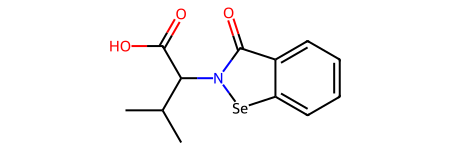

In [205]:
mol = AllChem.MolFromSmiles(smile)
mol

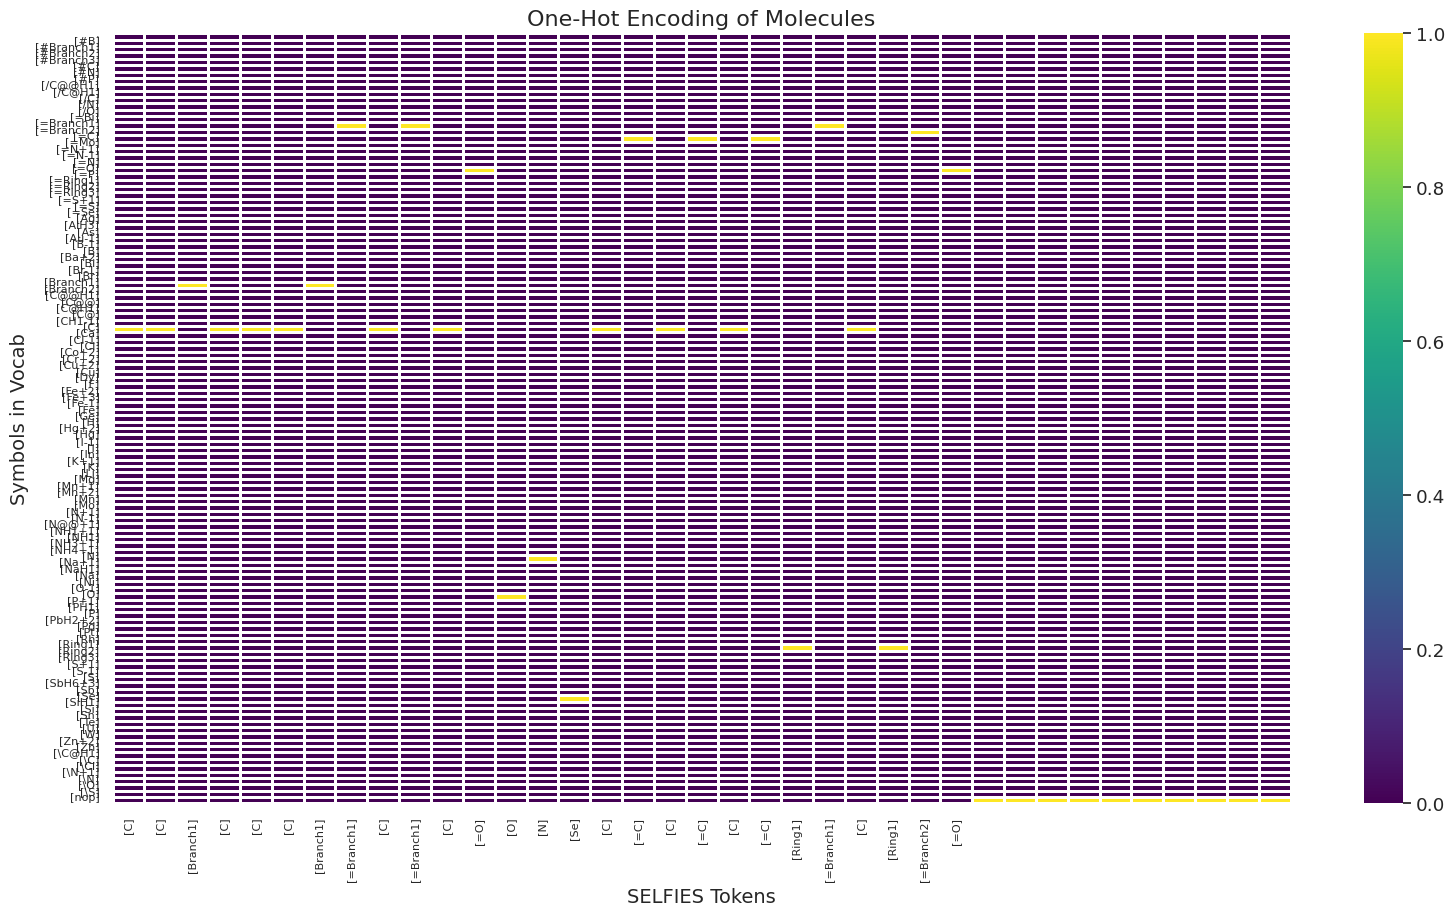

In [206]:
# Create a list of symbols ordered by the index in vocab_itos
ordered_symbols = [vocab_itos[i] for i in range(len(vocab_itos))]

plt.figure(figsize=(19, 10))
sns.set(font_scale=1.2)  # Increase font scale
heatmap = sns.heatmap(one_hot_encoded, cmap="viridis", cbar=True, linewidths=1,
                      yticklabels=ordered_symbols, xticklabels=selfies_tokens)  # y-axis: ordered_symbols, x-axis: selfies_tokens

# Adjusting ticks and labels
#heatmap.set_xticks(np.arange(len(selfies_tokens)))  # Set x-ticks for selfies_tokens
heatmap.set_xticklabels(selfies_tokens, rotation=90, fontsize=8)  # Set x-tick labels with font size
heatmap.set_yticks(np.arange(len(ordered_symbols)))  # Set y-ticks for ordered_symbols
heatmap.set_yticklabels(ordered_symbols, fontsize=8)  # Set y-tick labels with font size

heatmap.set_xlabel("SELFIES Tokens", fontsize=14)
heatmap.set_ylabel("Symbols in Vocab", fontsize=14)
heatmap.set_title("One-Hot Encoding of Molecules", fontsize=16)
plt.show()


Let's create a Data loader for this dataset.
1. We will transform each smile into its "figure" representation
2. Because we are working with two-classes, 'active' and 'inactive'. We also need to transform the label/class to one-hot encoding.

In [207]:
max_length = 0
for smile in balanced_data['smiles']:
    try:
        selfies_str = sf.encoder(smile)  # Convert to SELFIES
        length_selfies = sf.len_selfies(selfies_str)
        if length_selfies > max_length:
            max_length = length_selfies
    except sf.EncoderError:
        print(f"Skipping SMILES string due to encoding error: {smile}")

print('Max SELFIES length', max_length)


Max SELFIES length 245


In [220]:
# torch new data loader
class CustomDataset(Dataset):
    def __init__(self, smiles_all, labels_all, max_length, global_alphabet):
        self.labels = labels_all
        self.smiles = smiles_all
        self.max_length = max_length
        self.global_alphabet = global_alphabet
        self.symbol_to_index = {s: i for i, s in enumerate(sorted(self.global_alphabet))}

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        si = self.smiles[idx]
        labels = self.labels[idx]

        mi, _, _, _ = smiles_to_one_hot_and_list(si, self.max_length, self.global_alphabet)
        molecules_torch = torch.from_numpy(mi).float()
        labels_one_hot = F.one_hot(torch.tensor(labels), num_classes=2)

        return molecules_torch.unsqueeze(0), labels_one_hot

In [221]:
data_full = balanced_data
train_size = int(0.8 * len(data_full))  # 80% for training
validation_size = len(data_full) - train_size  # 20% for validation
print('Training data', train_size)
print('Test data', validation_size)
# train_dataset, validation_dataset = random_split(
#     data_full, [train_size, validation_size])
tr_dataset = data_full.sample(train_size)
val_dataset = data_full.sample(validation_size)


training_data = CustomDataset(
    tr_dataset['smiles'].to_list(), tr_dataset['NR-AR'].to_list(), max_length, global_alphabet)
train_dataloader = DataLoader(training_data, batch_size=512, shuffle=True)
train_molecules, train_labels = next(iter(train_dataloader))

print('Size of the training data')
print(train_molecules.shape)
print(train_labels.shape)

Training data 992
Test data 248
Size of the training data
torch.Size([512, 1, 245, 245])
torch.Size([512, 2])


## CNN ##

In [222]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )        # fully connected layer, output 10 classes
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 59 * 59, 512),
            nn.ReLU(),
            )

        self.fc2 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            )
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.conv2(x)
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        output = self.fc3(x)
        return output   # return x for visualization

In [223]:
def train(model, training_data, training_epochs=60,device='cuda'):
    # Define the loss function and optimizer
    model.train()
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    trainloader = torch.utils.data.DataLoader(
        training_data, batch_size=64, shuffle=True)

    iterator = tqdm.notebook.tqdm(range(training_epochs))

    # Run the training loop (epochs)
    loss_trajectory = []
    for epoch in iterator:

        # Set current loss value
        current_loss = []
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device) #new

            outputs = model(inputs)

            optimizer.zero_grad()

            loss = loss_function(outputs, targets.float())
            loss.backward()
            optimizer.step()

            # Print statistics
            # current_loss += loss.item()
            current_loss.append(loss.item())
        # print('Epoch %s: %.4f +- %.4f'%(epoch,np.array(current_loss).mean(),np.array(current_loss).std()))
        iterator.set_postfix(loss=torch.tensor(current_loss).mean())
        loss_trajectory.append(current_loss)
        # Process is complete.
    return loss_trajectory

In [224]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

PyTorch version: 2.2.1+cu121
TorchVision version: 0.17.1+cu121
Using device: cuda
Total free GPU memory: 14.471 GB
Total GPU memory: 15.836 GB


In [ ]:
cnn = CNN()
cnn.to(device)
compiled_cnn = torch.compile(cnn) # new!
print(train_molecules.shape)
# labels = cnn(train_molecules)
# print(labels)

loss_trj = train(cnn, training_data,100,device)


torch.Size([512, 1, 245, 245])


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
loss_trj = np.array(loss_trj)
m = np.mean(loss_trj,axis=1)
std = np.std(loss_trj,axis=1)

plt.errorbar(np.arange(m.shape[0]), m, yerr=std, errorevery=(0, 6))
plt.xlabel('Iterations')
plt.ylabel('Error')

## Save and Load modules ##

In [ ]:
# Specify a path
PATH = "state_dict_model.pt" #name of the file

# Save
torch.save(cnn.state_dict(), PATH)

# Load
model_new = CNN()
model_new.load_state_dict(torch.load(PATH))
model_new.eval()

labels = model_new(train_molecules)
print(labels)
!ls

# Prediction #

In [ ]:
val_data = CustomDataset(
    val_dataset ['smiles'].to_list(), val_dataset ['NR-AR'].to_list(), max_length, global_alphabet)
val_dataloader = DataLoader(val_data , batch_size=len(val_dataset), shuffle=True)

val_molecules, val_labels = next(iter(val_dataloader))
val_molecules, val_labels = val_molecules.to(device), val_labels.to(device)

cnn.eval()
val_labels_pred = cnn(val_molecules)

loss_function = nn.CrossEntropyLoss()
loss = loss_function(val_labels_pred, val_labels.float())
print(loss)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
# Calculate F1 score

actual_labels = val_labels.detach().cpu().numpy()
actual_labels = np.argmax(actual_labels,axis=1)
predictions = val_labels_pred.softmax(axis=1).detach().cpu().numpy()
predictions = np.argmax(predictions,axis=1)

f1 = f1_score(actual_labels, predictions, average='weighted')
print("F1 Score:", f1)

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(actual_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
